# **Chronic Kidney Disease ML Project**
## *By Ushna Saqib*


## Load Data & Import Libraries


In [ ]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
)

import joblib


In [ ]:
# Load dataset (make sure file is in the same folder as notebook)
df = pd.read_csv("Chronic_Kidney_disease_dataset.csv")

# Quick preview
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (30000, 25)


,age,gender,blood_pressure,specific_gravity,albumin,sugar,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,anemia,pedal_edema,ckd
0,62,female,50.0,1.020,4,4,normal,absent,absent,98.1,...,38.3,10132,5.8,yes,yes,yes,good,yes,no,1
1,44,female,90.4,1.010,1,0,normal,absent,absent,186.2,...,41.0,6703,6.0,yes,yes,no,good,yes,no,0
2,20,male,65.1,1.010,0,0,normal,absent,absent,201.3,...,36.5,6712,5.6,yes,no,no,good,no,no,0
3,66,female,99.1,1.025,2,0,normal,absent,absent,151.9,...,38.1,5327,5.7,no,yes,yes,good,yes,no,0
4,54,male,70.2,1.020,1,0,normal,absent,absent,163.7,...,31.4,6573,3.9,yes,yes,no,good,yes,no,0


In [ ]:
# Quick class distribution check (important!)
df["ckd"].value_counts()


,count
ckd,
0,25032
1,4968


## Data Preprocessing, EDA, and Train–Test Split

### Basic Data Checks

In [ ]:

# Check datatypes and missing values
df.info()

# Missing values count
df.isna().sum().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      30000 non-null  int64  
 1   gender                   30000 non-null  object 
 2   blood_pressure           30000 non-null  float64
 3   specific_gravity         30000 non-null  float64
 4   albumin                  30000 non-null  int64  
 5   sugar                    30000 non-null  int64  
 6   pus_cell                 30000 non-null  object 
 7   pus_cell_clumps          30000 non-null  object 
 8   bacteria                 30000 non-null  object 
 9   blood_glucose_random     30000 non-null  float64
 10  blood_urea               30000 non-null  float64
 11  serum_creatinine         30000 non-null  float64
 12  sodium                   30000 non-null  float64
 13  potassium                30000 non-null  float64
 14  hemoglobin            

,0
age,0
gender,0
blood_pressure,0
specific_gravity,0
albumin,0
sugar,0
pus_cell,0
pus_cell_clumps,0
bacteria,0
blood_glucose_random,0


### UNIVARIATE ANALYSIS

### Histograms (Distribution / Normality Check)

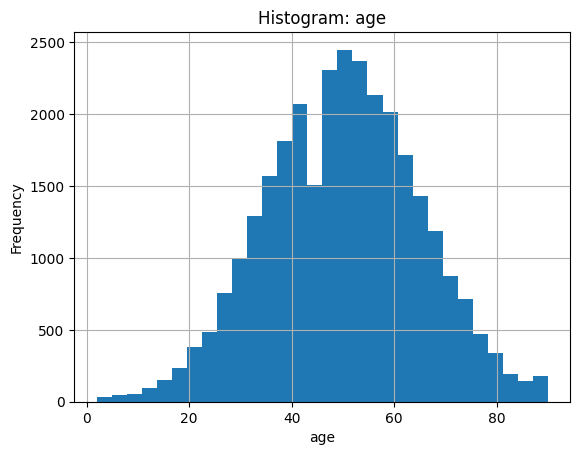

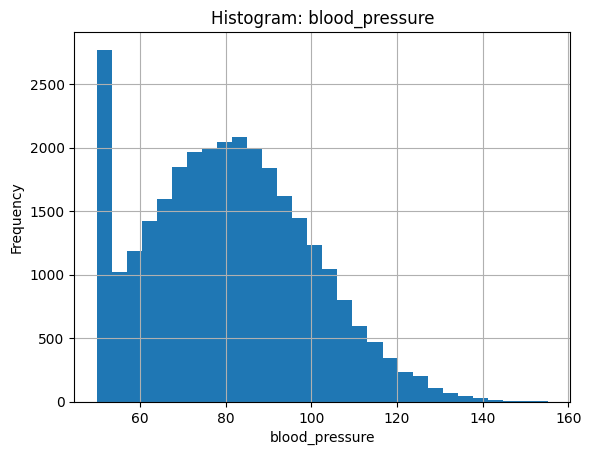

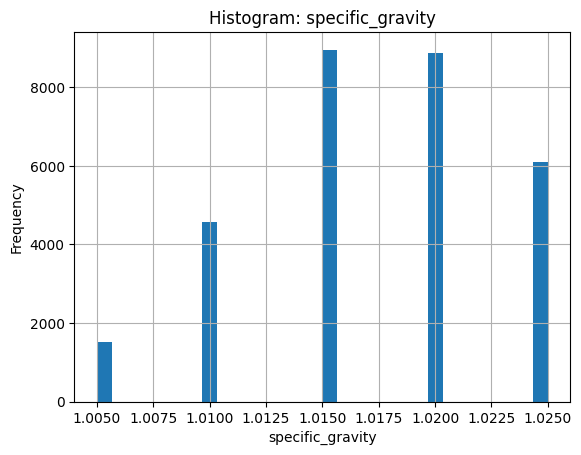

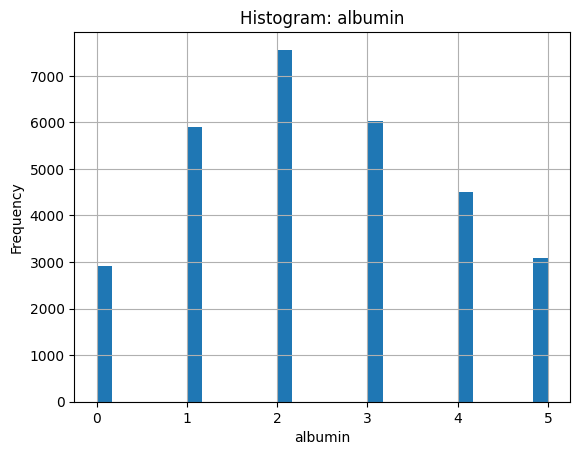

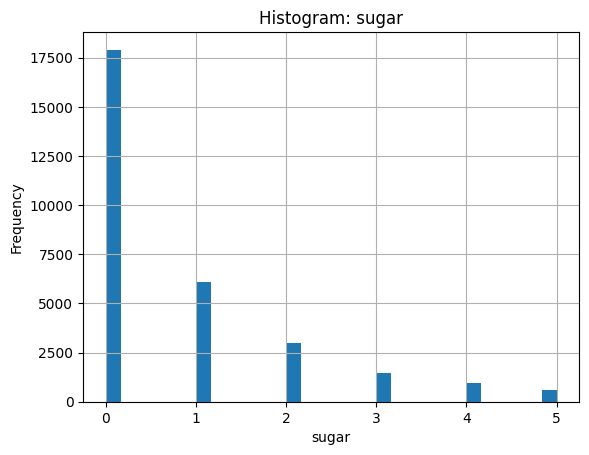

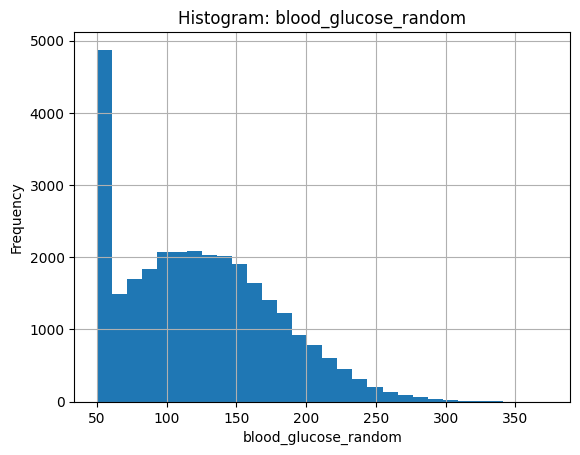

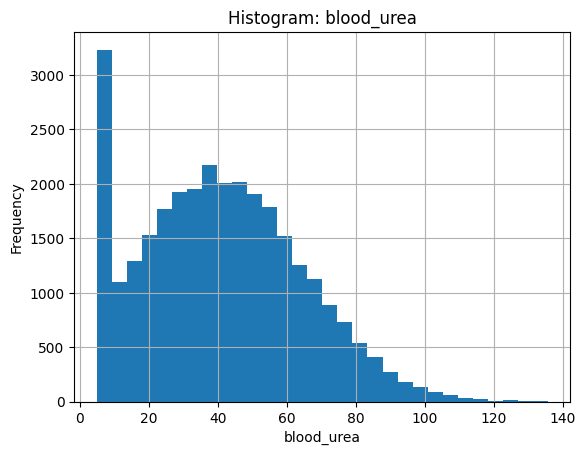

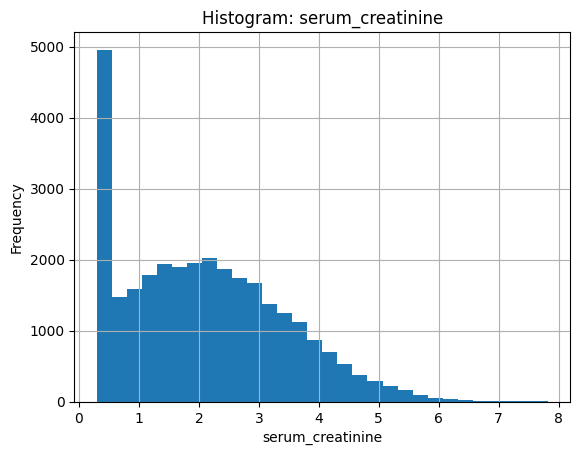

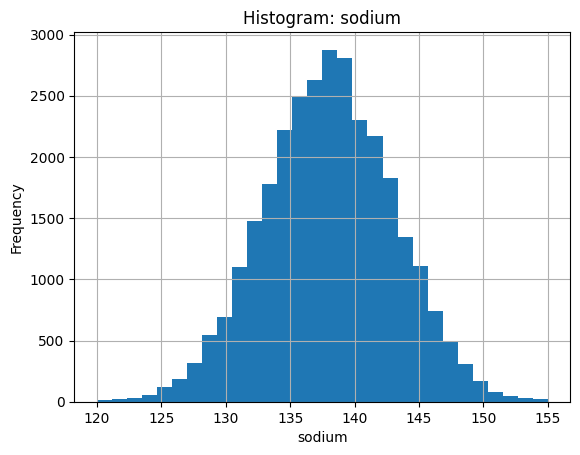

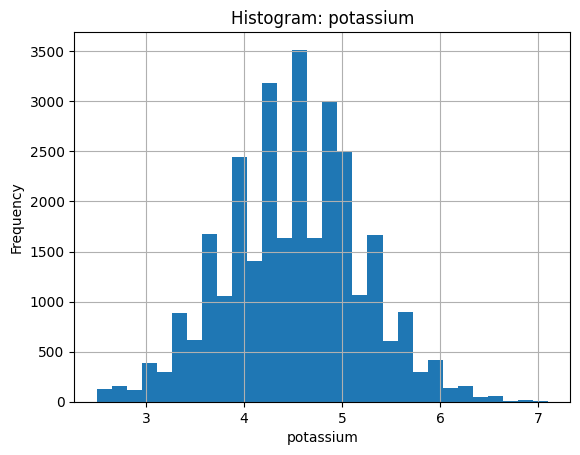

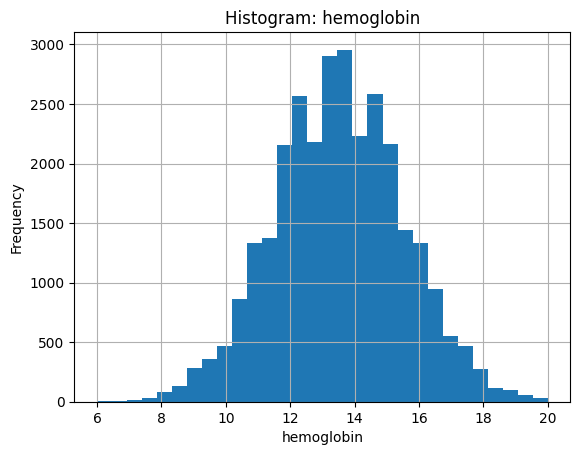

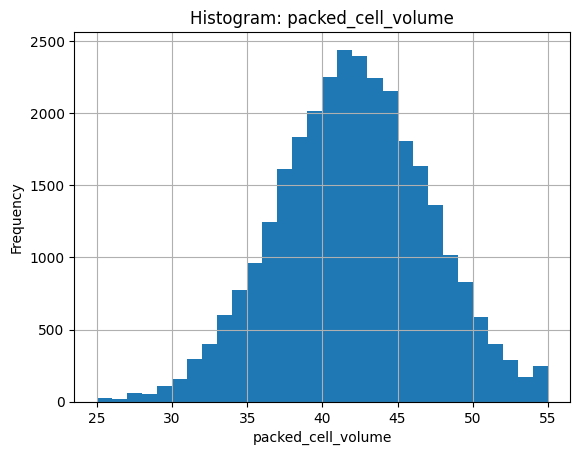

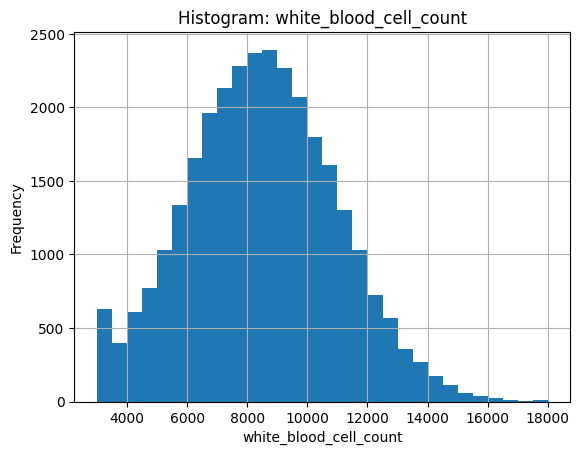

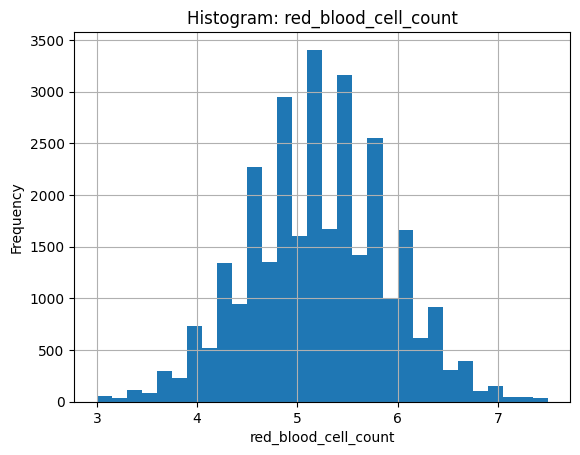

In [ ]:
# Identify numerical columns (excluding target)
num_cols_all = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_cols = [c for c in num_cols_all if c != "ckd"]

# Plot histograms for numerical features
for col in num_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


### Boxplots (Outlier Detection)

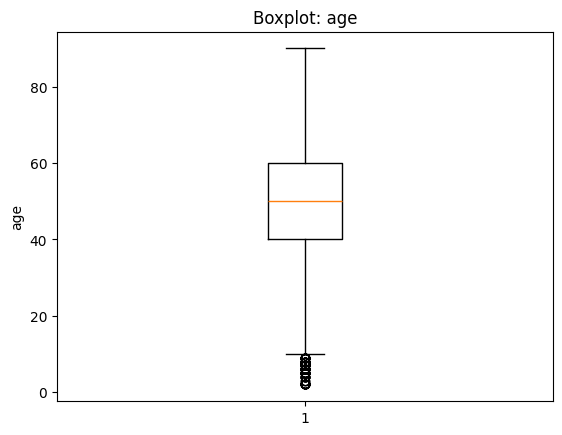

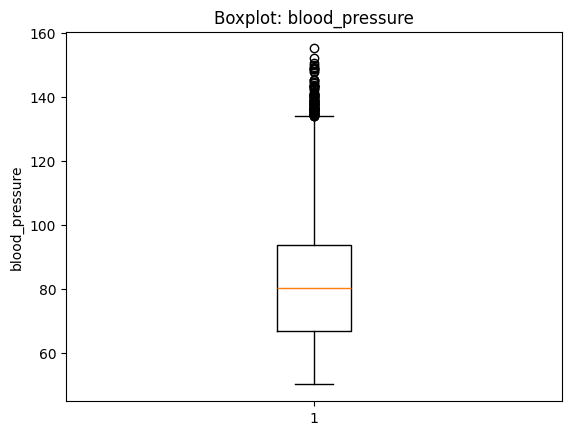

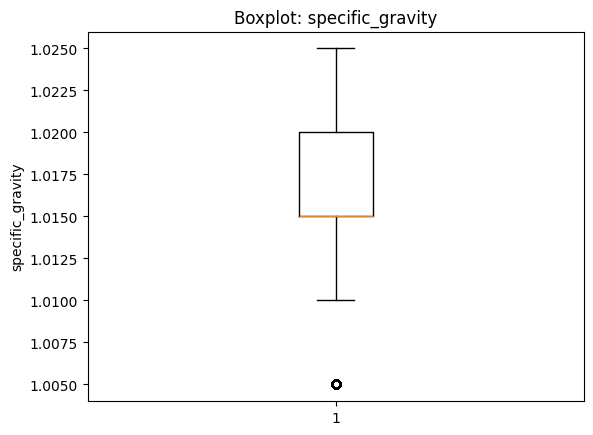

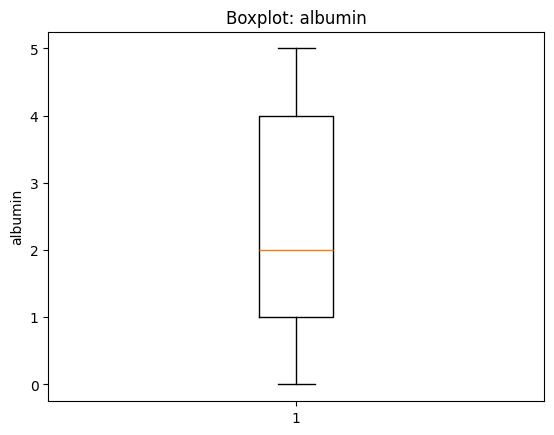

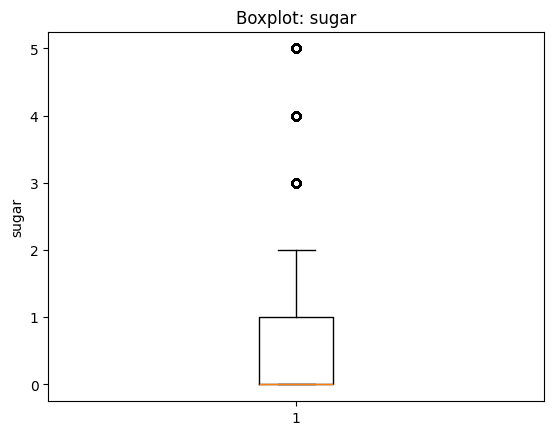

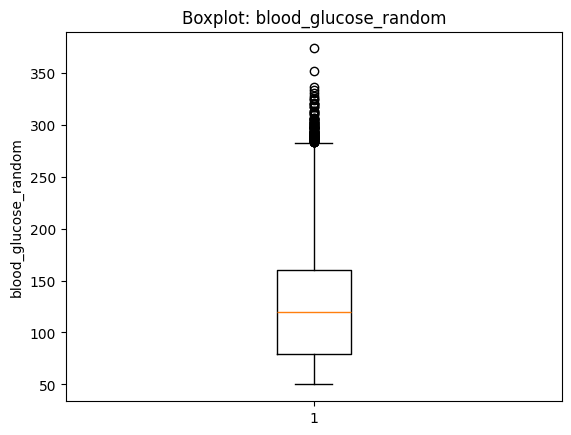

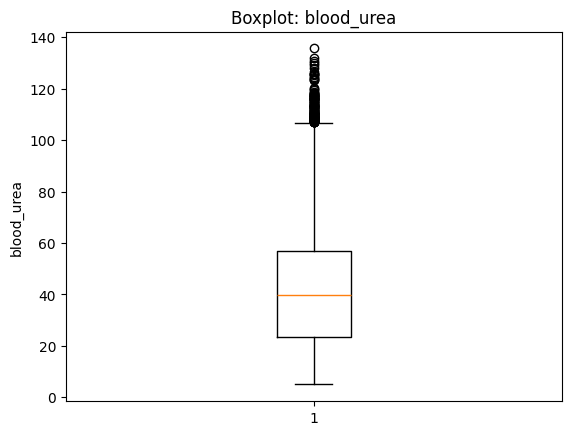

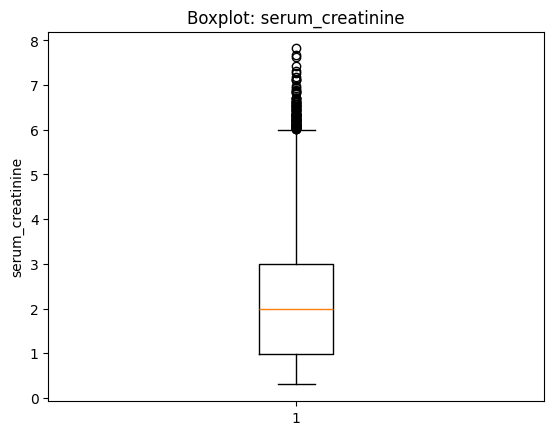

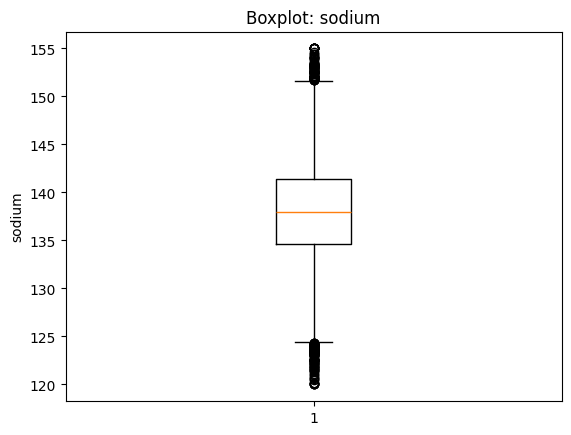

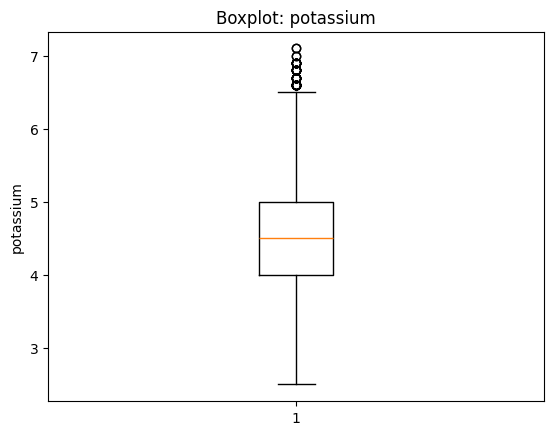

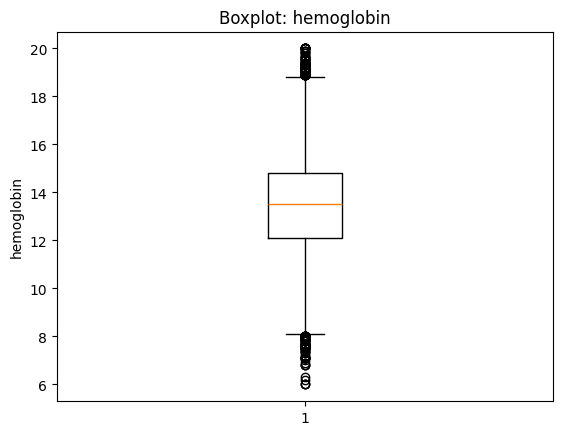

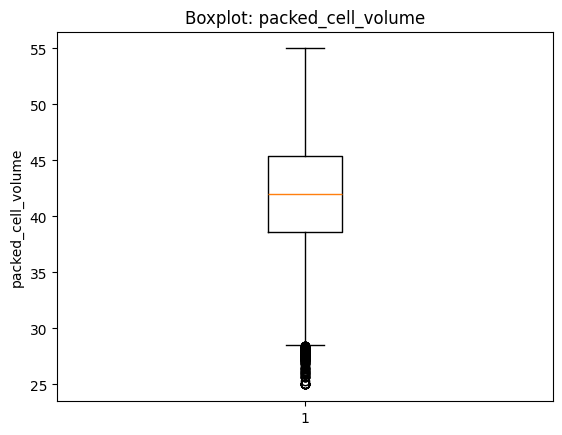

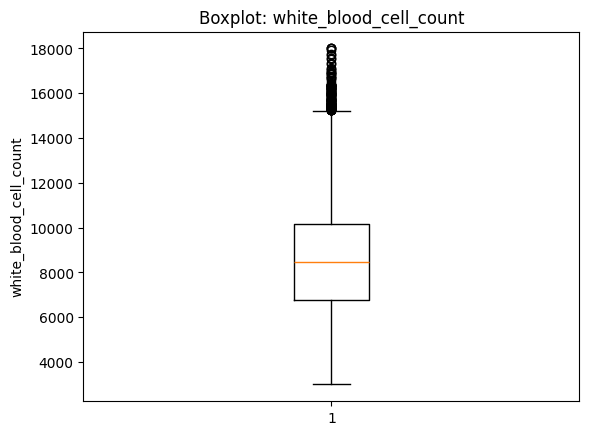

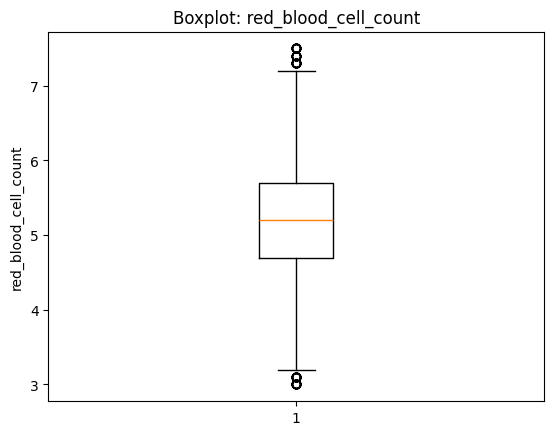

In [ ]:
# Boxplots for numerical columns to detect outliers
for col in num_cols:
    plt.figure()
    plt.boxplot(df[col].dropna())
    plt.title(f"Boxplot: {col}")
    plt.ylabel(col)
    plt.show()


### BIVARIATE ANALYSIS

### Split Features and Target + Train-Test Split

In [ ]:
# Separate features (X) and target (y)
X = df.drop("ckd", axis=1)
y = df["ckd"]

# Identify numeric vs categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)


Numeric: ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium', 'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count']
Categorical: ['gender', 'pus_cell', 'pus_cell_clumps', 'bacteria', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'anemia', 'pedal_edema']


In [ ]:
# Train-test split (stratify keeps class ratio consistent)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())


Train class distribution:
 ckd
0    20026
1     3974
Name: count, dtype: int64
Test class distribution:
 ckd
0    5006
1     994
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

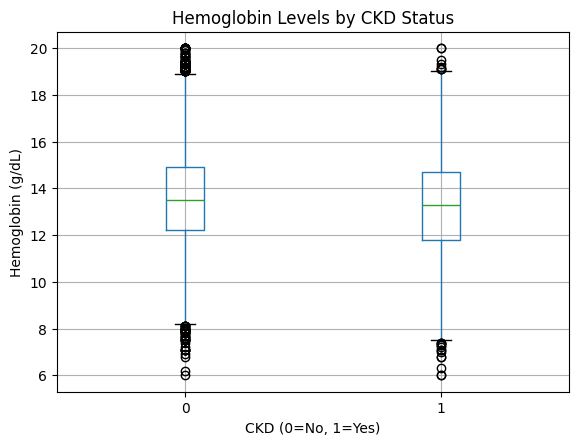

In [ ]:
plt.figure()
df.boxplot(column="hemoglobin", by="ckd")
plt.title("Hemoglobin Levels by CKD Status")
plt.suptitle("")
plt.xlabel("CKD (0=No, 1=Yes)")
plt.ylabel("Hemoglobin (g/dL)")
plt.show()


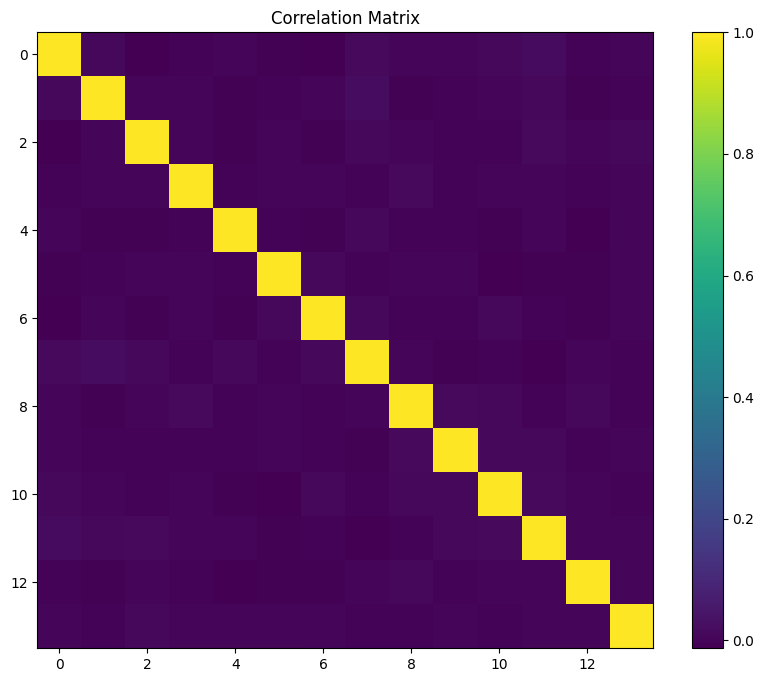

In [ ]:
corr = df[num_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr)
plt.colorbar()
plt.title("Correlation Matrix")
plt.show()


## Model Training

### Build Preprocessing Pipelines

In [ ]:
# Numeric preprocessing:
# - Fill missing values with median
# - Scale features (important for Logistic Regression)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing:
# - Fill missing values with most frequent category
# - One-hot encode categories
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing for numeric + categorical
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)


### Train Random Forest

In [ ]:
# Random Forest pipeline
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42))
])

# Train model
rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'blood_pressure',
                                                   'specific_gravity',
                                                   'albumin', 'sugar',
                                                   'blood_glucose_random',
                                                   'blood_urea',
                                                   'serum_creatinine', 'sodium',
                                                   'potassium', 'hemoglobin',
                                                   'packed_cell_volume',
                                                   'white_blood_cell_c...
                                                   'red_blood_cell_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'pus_cell',
                                                   'pus_cell_clumps',
                                                   'bacteria', 'hypertension',
                                                   'diabetes_mellitus',
                                                   'coronary_artery_disease',
                                                   'appetite', 'anemia',
                                                   'pedal_edema'])])),
                ('model', RandomForestClassifier(random_state=42))])

### Train Logistic Regression

In [ ]:
# Logistic Regression pipeline
# class_weight="balanced" helps handle imbalanced target
log_reg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

# Train model
log_reg_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'blood_pressure',
                                                   'specific_gravity',
                                                   'albumin', 'sugar',
                                                   'blood_glucose_random',
                                                   'blood_urea',
                                                   'serum_creatinine', 'sodium',
                                                   'potassium', 'hemoglobin',
                                                   'packed_cell_volume',
                                                   'white_blood_cell_c...
                                                   'red_blood_cell_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'pus_cell',
                                                   'pus_cell_clumps',
                                                   'bacteria', 'hypertension',
                                                   'diabetes_mellitus',
                                                   'coronary_artery_disease',
                                                   'appetite', 'anemia',
                                                   'pedal_edema'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

### Train Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=42))
])

dt_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'blood_pressure',
                                                   'specific_gravity',
                                                   'albumin', 'sugar',
                                                   'blood_glucose_random',
                                                   'blood_urea',
                                                   'serum_creatinine', 'sodium',
                                                   'potassium', 'hemoglobin',
                                                   'packed_cell_volume',
                                                   'white_blood_cell_c...
                                                   'red_blood_cell_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'pus_cell',
                                                   'pus_cell_clumps',
                                                   'bacteria', 'hypertension',
                                                   'diabetes_mellitus',
                                                   'coronary_artery_disease',
                                                   'appetite', 'anemia',
                                                   'pedal_edema'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

### Train KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", KNeighborsClassifier(n_neighbors=7))
])

knn_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'blood_pressure',
                                                   'specific_gravity',
                                                   'albumin', 'sugar',
                                                   'blood_glucose_random',
                                                   'blood_urea',
                                                   'serum_creatinine', 'sodium',
                                                   'potassium', 'hemoglobin',
                                                   'packed_cell_volume',
                                                   'white_blood_cell_c...,
                                                   'red_blood_cell_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'pus_cell',
                                                   'pus_cell_clumps',
                                                   'bacteria', 'hypertension',
                                                   'diabetes_mellitus',
                                                   'coronary_artery_disease',
                                                   'appetite', 'anemia',
                                                   'pedal_edema'])])),
                ('model', KNeighborsClassifier(n_neighbors=7))])

## Model Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test, name="Model"):

    # Predict class labels
    y_pred = model.predict(X_test)

    # Probability scores for ROC-AUC (if available)
    y_prob = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n===== {name} =====")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-score :", f1_score(y_test, y_pred))

    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # ROC-AUC (only if probabilities exist)
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
        print("ROC-AUC  :", auc)

        RocCurveDisplay.from_predictions(y_test, y_prob)
        plt.title(f"ROC Curve - {name}")
        plt.show()


### Logistic Regression


===== Logistic Regression =====
Accuracy : 0.7978333333333333
Precision: 0.4411606663084363
Recall   : 0.8259557344064387
F1-score : 0.5751313485113836

Confusion Matrix:
 [[3966 1040]
 [ 173  821]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.79      0.87      5006
           1       0.44      0.83      0.58       994

    accuracy                           0.80      6000
   macro avg       0.70      0.81      0.72      6000
weighted avg       0.87      0.80      0.82      6000

ROC-AUC  : 0.8695022713186833


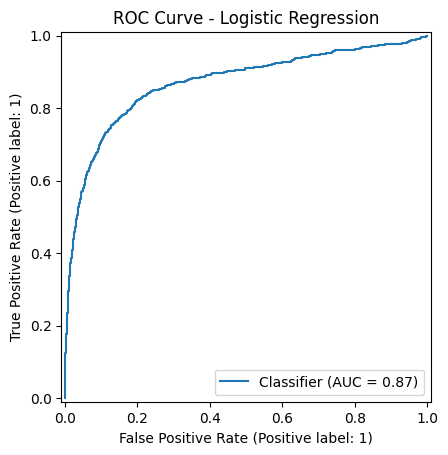

In [ ]:
# Evaluate Logistic Regression
evaluate_model(log_reg_model, X_test, y_test, "Logistic Regression")


### Random Forest


===== Random Forest =====
Accuracy : 0.9681666666666666
Precision: 0.9684947491248541
Recall   : 0.8350100603621731
F1-score : 0.8968125337655322

Confusion Matrix:
 [[4979   27]
 [ 164  830]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5006
           1       0.97      0.84      0.90       994

    accuracy                           0.97      6000
   macro avg       0.97      0.91      0.94      6000
weighted avg       0.97      0.97      0.97      6000

ROC-AUC  : 0.9167745184651657


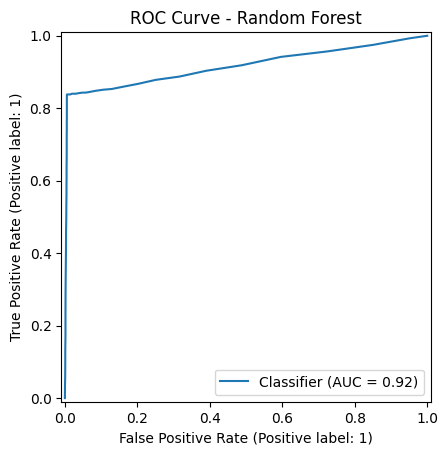

In [ ]:
# Evaluate Random Forest
evaluate_model(rf_model, X_test, y_test, "Random Forest")


### Decision Tree


===== Decision Tree =====
Accuracy : 0.933
Precision: 0.7924901185770751
Recall   : 0.806841046277666
F1-score : 0.7996011964107677

Confusion Matrix:
 [[4796  210]
 [ 192  802]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      5006
           1       0.79      0.81      0.80       994

    accuracy                           0.93      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.93      0.93      0.93      6000

ROC-AUC  : 0.8824456929350775


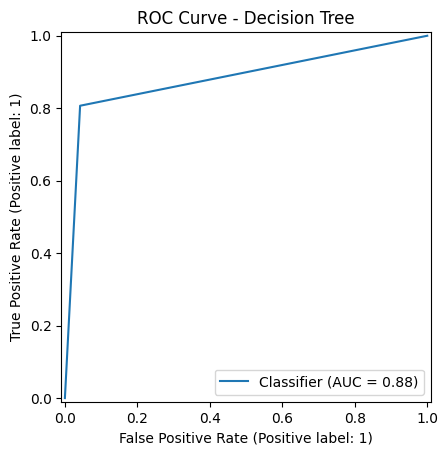

In [ ]:
# decision tree
evaluate_model(dt_model, X_test, y_test, "Decision Tree")


### KNN


===== KNN =====
Accuracy : 0.8696666666666667
Precision: 0.8081395348837209
Recall   : 0.2796780684104628
F1-score : 0.4155455904334828

Confusion Matrix:
 [[4940   66]
 [ 716  278]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93      5006
           1       0.81      0.28      0.42       994

    accuracy                           0.87      6000
   macro avg       0.84      0.63      0.67      6000
weighted avg       0.86      0.87      0.84      6000

ROC-AUC  : 0.8215575916546021


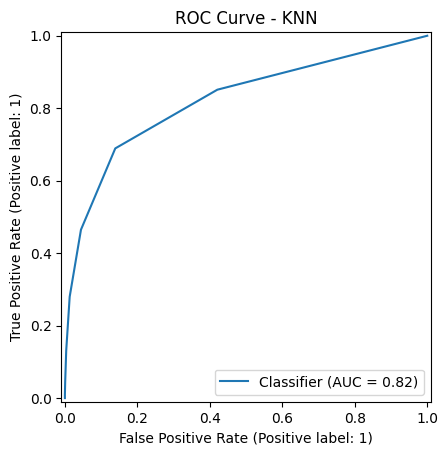

In [ ]:
#KNN
evaluate_model(knn_model, X_test, y_test, "KNN")


### Cross Validation

In [ ]:
# Cross-validation (F1-score) to check robustness
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="f1")
print("RF CV F1 scores:", rf_cv_scores)
print("Mean RF CV F1:", rf_cv_scores.mean())


RF CV F1 scores: [0.88279644 0.90261921 0.90322581 0.89534099 0.89594595]
Mean RF CV F1: 0.8959856763309576


## Testing on New Instances (Experiment Mode)

In [ ]:
# Example new patient record (low risk)
new_patient = {
    "age": 55,
    "gender": "male",
    "blood_pressure": 145,
    "specific_gravity": 1.010,
    "albumin": 2,
    "sugar": 1,
    "pus_cell": "abnormal",
    "pus_cell_clumps": "present",
    "bacteria": "present",
    "blood_glucose_random": 210,
    "blood_urea": 55,
    "serum_creatinine": 2.1,
    "sodium": 130,
    "potassium": 5.8,
    "hemoglobin": 10.5,
    "packed_cell_volume": 28,
    "white_blood_cell_count": 12000,
    "red_blood_cell_count": 3.8,
    "hypertension": "yes",
    "diabetes_mellitus": "yes",
    "coronary_artery_disease": "no",
    "appetite": "poor",
    "anemia": "yes",
    "pedal_edema": "yes"
}

new_df = pd.DataFrame([new_patient])

pred = rf_model.predict(new_df)[0]
prob = rf_model.predict_proba(new_df)[0][1]

print("Predicted CKD (1=Yes, 0=No):", int(pred))
print("Probability of CKD:", prob)


Predicted CKD (1=Yes, 0=No): 0
Probability of CKD: 0.27


In [ ]:
# high risk patient
high_risk_patient = {
    "age": 72,
    "gender": "male",
    "blood_pressure": 180,
    "specific_gravity": 1.005,
    "albumin": 4,
    "sugar": 3,
    "pus_cell": "abnormal",
    "pus_cell_clumps": "present",
    "bacteria": "present",
    "blood_glucose_random": 290,
    "blood_urea": 85,
    "serum_creatinine": 4.2,
    "sodium": 125,
    "potassium": 6.3,
    "hemoglobin": 8.5,
    "packed_cell_volume": 26,
    "white_blood_cell_count": 15000,
    "red_blood_cell_count": 3.2,
    "hypertension": "yes",
    "diabetes_mellitus": "yes",
    "coronary_artery_disease": "yes",
    "appetite": "poor",
    "anemia": "yes",
    "pedal_edema": "yes"
}

high_df = pd.DataFrame([high_risk_patient])

pred = rf_model.predict(high_df)[0]
prob = rf_model.predict_proba(high_df)[0][1]

print("Predicted CKD (1=Yes, 0=No):", int(pred))
print("Probability of CKD:", prob)


Predicted CKD (1=Yes, 0=No): 1
Probability of CKD: 0.65


## Model Optimization: Hyperparameter Tuning (Random Forest)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "model__n_estimators": [100, 150],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

rf_tune = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42))
])

random_search = RandomizedSearchCV(
    rf_tune,
    param_distributions=param_dist,
    n_iter=10,          # Only try 10 combinations
    cv=3,               # 3-fold CV (faster)
    scoring="f1",
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best CV F1:", random_search.best_score_)

best_model = random_search.best_estimator_


Best Params: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None}
Best CV F1: 0.8946727444163528



===== Tuned Random Forest =====
Accuracy : 0.9681666666666666
Precision: 0.9684947491248541
Recall   : 0.8350100603621731
F1-score : 0.8968125337655322

Confusion Matrix:
 [[4979   27]
 [ 164  830]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5006
           1       0.97      0.84      0.90       994

    accuracy                           0.97      6000
   macro avg       0.97      0.91      0.94      6000
weighted avg       0.97      0.97      0.97      6000

ROC-AUC  : 0.9167745184651657


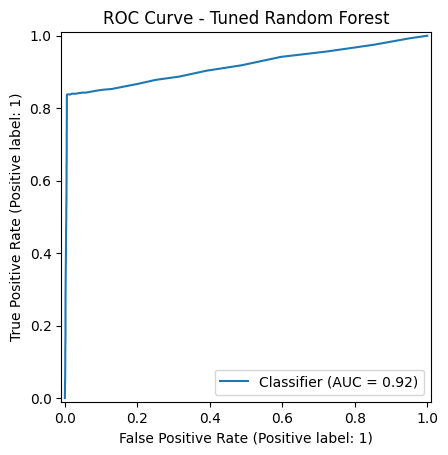

In [ ]:
evaluate_model(best_model, X_test, y_test, "Tuned Random Forest")


### MODEL INTERPRETATION

### Feature Importance

In [ ]:
# Get trained Random Forest inside pipeline
rf_final = best_model.named_steps["model"]

# Get feature names after encoding
feature_names = best_model.named_steps["preprocess"].get_feature_names_out()

importances = rf_final.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feat_imp.head(15)


,feature,importance
7,num__serum_creatinine,0.249468
6,num__blood_urea,0.140539
3,num__albumin,0.113890
23,cat__hypertension_yes,0.093179
22,cat__hypertension_no,0.084043
10,num__hemoglobin,0.061820
12,num__white_blood_cell_count,0.027041
8,num__sodium,0.026195
1,num__blood_pressure,0.025038
11,num__packed_cell_volume,0.024906


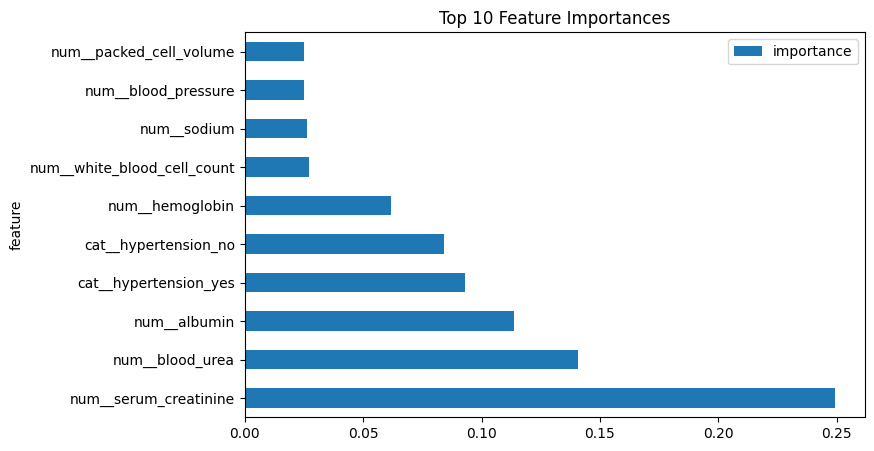

In [ ]:
feat_imp.head(10).plot(
    x="feature", y="importance", kind="barh", figsize=(8,5), title="Top 10 Feature Importances"
)
plt.show()


### Logistic Regression Coefficients

In [ ]:
log_model = log_reg_model.named_steps["model"]
log_features = log_reg_model.named_steps["preprocess"].get_feature_names_out()

coef_df = pd.DataFrame({
    "feature": log_features,
    "coefficient": log_model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df.head(10)


,feature,coefficient
23,cat__hypertension_yes,1.147928
7,num__serum_creatinine,0.972369
6,num__blood_urea,0.662422
3,num__albumin,0.543851
19,cat__pus_cell_clumps_present,0.033018
12,num__white_blood_cell_count,0.021391
8,num__sodium,0.021282
5,num__blood_glucose_random,0.019780
29,cat__appetite_poor,0.019457
2,num__specific_gravity,0.013237


## Model Serialization (Save + Load Model)

In [ ]:
# Save the tuned best model, random forest, to disk
joblib.dump(best_model, "ckd_best_model.pkl")

print("Model successfully saved as ckd_best_model.pkl")


Model successfully saved as ckd_best_model.pkl
